In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import pathlib
import PIL
from PIL import Image 
from PIL.ImageDraw import Draw

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Processing Data

In [2]:
def getImagesTargetsLabels(CSV_FILE, IMAGE_DIR):
    image_records = pd.read_csv(CSV_FILE)
    image_path = os.path.join(os.getcwd(), IMAGE_DIR)

    images, targets, labels = ([], [], [])

    for row in image_records.values:
        (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row
        
        train_image_fullpath = os.path.join(image_path, filename)
        train_img = keras.preprocessing.image.load_img(train_image_fullpath, target_size=(height, width))
        train_img_arr = keras.preprocessing.image.img_to_array(train_img)
        train_img_arr = train_img_arr/255.
        
        xmin = round(xmin/ width, 2)
        ymin = round(ymin/ height, 2)
        xmax = round(xmax/ width, 2)
        ymax = round(ymax/ height, 2)
        
        images.append(train_img_arr)
        targets.append((xmin, ymin, xmax, ymax))    
        labels.append(classes.index(class_name))
    
    return np.array(images), np.array(targets), np.array(labels)

In [3]:
TRAINING_CSV_FILE = os.path.join(os.getcwd(), 'Tensorflow', 'workspace', 'data', 'train.csv')
TRAINING_IMAGE_DIR = os.path.join(os.getcwd(), 'Tensorflow', 'workspace', 'images', 'train')

TESTING_CSV_FILE = os.path.join(os.getcwd(), 'Tensorflow', 'workspace', 'data', 'test.csv')
TESTING_IMAGE_DIR = os.path.join(os.getcwd(), 'Tensorflow', 'workspace', 'images', 'test')

In [4]:
width = 640
height = 480

classes = ['thumbsup', 'thumbsdown', 'jutsu',]
num_classes = len(classes)

In [5]:
train_images, train_targets, train_labels = getImagesTargetsLabels(TRAINING_CSV_FILE, TRAINING_IMAGE_DIR)
test_images, test_targets, test_labels = getImagesTargetsLabels(TESTING_CSV_FILE, TESTING_IMAGE_DIR)

## Model Creation

In [6]:
# #create the common input layer
# input_shape = (height, width, 3)
# input_layer = tf.keras.layers.Input(input_shape)

# #create the base layers
# base_layers = layers.experimental.preprocessing.Rescaling(1./1, name='bl_1')(input_layer)
# base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
# base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
# base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
# base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
# base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
# base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
# base_layers = layers.Flatten(name='bl_8')(base_layers)

# #create the classifier branch
# classifier_branch = layers.Dense(128, activation='relu', name='cl_1')(base_layers)
# classifier_branch = layers.Dense(num_classes, name='classifier')(classifier_branch)  

# #create the localiser branch
# locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
# locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
# locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
# locator_branch = layers.Dense(4, activation='sigmoid', name='bounding_box')(locator_branch)

In [7]:
#create the common input layer
input_shape = (height, width, 3)
input_layer = tf.keras.layers.Input(input_shape)

#create the base layers
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu',) (input_layer)
base_layers = layers.MaxPooling2D() (base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', ) (base_layers)
base_layers = layers.MaxPooling2D() (base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu',) (base_layers)
base_layers = layers.MaxPooling2D() (base_layers)
base_layers = layers.Flatten() (base_layers)

#create the classifier branch
classifier_branch = layers.Dense(128, activation='relu', name='cl_1')(base_layers)
classifier_branch = layers.Dense(num_classes, name='classifier')(classifier_branch)  

#create the localiser branch
locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bounding_box')(locator_branch)

In [8]:
model = tf.keras.Model(
                input_layer,
                outputs=[classifier_branch, locator_branch]
            )

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 480, 640, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 240, 320, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [10]:
losses = {"classifier":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
            "bounding_box":tf.keras.losses.MSE}


model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])

In [11]:
training_epochs = 30

trainTargets = {
    "classifier": train_labels,
    "bounding_box": train_targets
}
validationTargets = {
    "classifier": test_labels,
    "bounding_box": test_targets
}

In [12]:
history = model.fit(train_images, trainTargets,
                validation_data=(test_images, validationTargets),
                epochs=training_epochs,
                batch_size=4,
                shuffle=True,)

Epoch 1/30
14/14 [==============================] - 22s 1s/step - loss: 3.4958 - classifier_loss: 3.4291 - bounding_box_loss: 0.0667 - classifier_accuracy: 0.3929 - bounding_box_accuracy: 0.8214 - val_loss: 1.1371 - val_classifier_loss: 1.1245 - val_bounding_box_loss: 0.0126 - val_classifier_accuracy: 0.3333 - val_bounding_box_accuracy: 1.0000
Epoch 2/30
14/14 [==============================] - 20s 1s/step - loss: 1.0678 - classifier_loss: 1.0477 - bounding_box_loss: 0.0200 - classifier_accuracy: 0.4464 - bounding_box_accuracy: 0.8929 - val_loss: 0.5789 - val_classifier_loss: 0.5718 - val_bounding_box_loss: 0.0071 - val_classifier_accuracy: 1.0000 - val_bounding_box_accuracy: 1.0000
Epoch 3/30
14/14 [==============================] - 18s 1s/step - loss: 0.7080 - classifier_loss: 0.6883 - bounding_box_loss: 0.0197 - classifier_accuracy: 0.7143 - bounding_box_accuracy: 0.8929 - val_loss: 0.2665 - val_classifier_loss: 0.2579 - val_bounding_box_loss: 0.0087 - val_classifier_accuracy: 1.000

## Testing

### Manual

In [13]:
def getOriginalBBOX(bbox, width, height):
    bbox = bbox.squeeze()
    xmin = bbox[0] * width
    ymin = bbox[1] * height
    xmax = bbox[2] * width
    ymax = bbox[3] * height
    return xmin, ymin, xmax, ymax

In [14]:
predicting = test_images[2]
cl_predict, bbox_predict = model.predict(np.expand_dims(predicting, axis=0))

print(cl_predict)
print(bbox_predict)

[[ 11.869861   -5.7975416 -18.640663 ]]
[[0.55875975 0.63736516 0.8150573  0.99025315]]


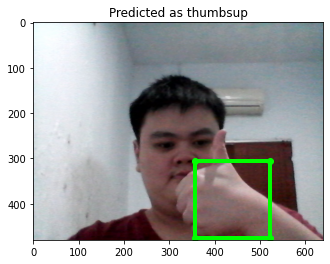

In [15]:
plt.title(f'Predicted as {classes[np.argmax(cl_predict)]}')
plt.imshow(predicting)
x_min, y_min, x_max, y_max = getOriginalBBOX(bbox_predict, width, height)

scatter_color = 'lime'
lw = 4

plt.scatter(x_min, y_min, color=scatter_color)
plt.scatter(x_min, y_max, color=scatter_color)
plt.scatter(x_max, y_min, color=scatter_color)
plt.scatter(x_max, y_max, color=scatter_color)

# buat linenya
# Todo: vertikal kiri
y1_ver = np.arange(y_min, y_max)
x1_ver = [x_min for i in range(len(y1_ver))]
plt.plot(x1_ver, y1_ver, color=scatter_color, linewidth=lw) 

# # Todo: vertikal kanan
x2_ver = [x_max for i in range(len(y1_ver))]
plt.plot(x2_ver, y1_ver, color=scatter_color, linewidth=lw)

# # Todo: horizontal atas
x1_hor = np.arange(x_min, x_max)
y1_hor = [y_min for i in range(len(x1_hor))]
plt.plot(x1_hor, y1_hor, color=scatter_color, linewidth=lw)

# # Todo: horizontal bawah
y2_hor = [y_max for i in range(len(x1_hor))]
plt.plot(x1_hor, y2_hor, color=scatter_color, linewidth=lw)

### CV

In [16]:
import cv2 

In [18]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32) / 255.
    
    cl_predict, bbox_predict = model.predict(input_tensor)
    
    predicted = classes[np.argmax(cl_predict)]
    x_min, y_min, x_max, y_max = getOriginalBBOX(bbox_predict, width, height)
    
    # print(classes[np.argmax(cl_predict)])
    # print(bbox_predict)
    # print(x_min, y_min, x_max, y_max)
    
    # Window name in which image is displayed
    window_name = 'Image'
    
    # represents the top left corner of rectangle
    start_point = (int(x_min), int(y_min))
    
    # represents the bottom right corner of rectangle
    end_point = (int(x_max), int(y_max))
    
    color = (0, 255, 0)
    # Line thickness of 2 px
    thickness = 2
    
    # Using cv2.rectangle() method
    image = cv2.rectangle(image_np, start_point, end_point, color, thickness)
    # cv2.putText(image, predicted, (int(x_min), int(y_min)-10), 
    #                 cv2.FONT_HERSHEY_SIMPLEX, 0.9, (int(x_max), int(y_max)), 2)
    
    #  put text: image, label, lokasi pojok kiri atas, font, fontscale, text color, font tickness
    cv2.putText(image, predicted, (int(x_min), int(y_min)-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Displaying the image 
    cv2.imshow(window_name, image) 

    # cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (width, height)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break